In [46]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

In [47]:
# Make classification data
from sklearn.datasets import make_circles
import pandas as pd

# Make 1000 samples
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=22)
print(len(X), len(y))
print(X[:3], y[:3]) # Binary classification

# Make a DataFrame in Pandas
circles = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], "label": y})
circles.head()

1000 1000
[[-0.07549684 -0.80314814]
 [-0.74387864  0.6962981 ]
 [-0.78619432  0.15407946]] [1 0 1]


,X1,X2,label
0,-0.075497,-0.803148,1
1,-0.743879,0.696298,0
2,-0.786194,0.154079,1
3,-0.328933,0.724594,1
4,-0.384839,0.879087,0


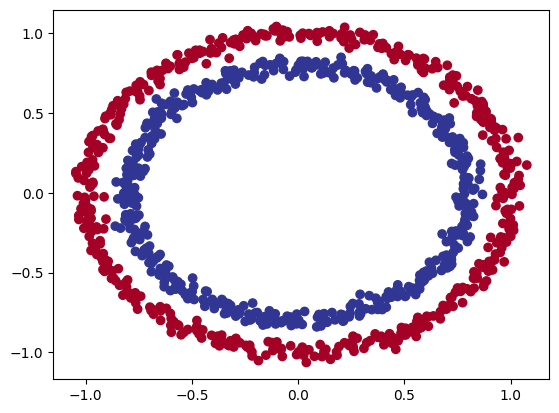

In [48]:
# Visualize

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


In [49]:
# Check input and output shapes
from sklearn.model_selection import train_test_split

print(X.shape, y.shape)
print(X[0], y[0])

# Turn data into tensors

X = torch.from_numpy(X).type(torch.float) # Need it to be float32
y = torch.from_numpy(y).type(torch.float)

# Create train and test splits, random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

(1000, 2) (1000,)
[-0.07549684 -0.80314814] 1


In [50]:
# We will make a nn, with 2 nn.Linear() layers
# nn.Linear() Applies an affine linear transformation to the incoming data:
# y = xA^T + b

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 layers
    # 2 in features, and we want to map it to 1 output feature
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Arbitrary out for layer 1
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Output layer, same output shape as y

  # Forward pass through the whole network
  def forward(self, x):
    return self.layer_2(self.later_1(x))

model = CircleModelV0().to(device)

In [51]:
# Replicate the model using nn.Sequential()

model = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                      nn.Linear(in_features=5, out_features=1)).to(device)

model

# Make predictions, they are not in the same forma

with torch.inference_mode():
  untrained_preds = model(X_test.to(device))
print(untrained_preds[:10], y_test[:10]) # Logits, need activation function

tensor([[-0.7681],
        [-0.4154],
        [-0.7600],
        [-0.4850],
        [-0.6570],
        [-0.7266],
        [-0.7233],
        [-0.7030],
        [-0.5479],
        [-0.5272]], device='cuda:0') tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.])


In [52]:
# Setup loss funciton and optimizer
# Use cross-entropy loss since this is a classification problem
# The tallies, the last linear layer that adds all the scores and tallies them to next step,
# Are called logits, passed into sigmoid/softmax, then we can round

loss = nn.BCEWithLogitsLoss() # Has sigmoid activation function built in
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Calculate accuracy (TP / TP + TN)
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [53]:
# Training loop

torch.manual_seed(22)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# This loop can be functionized
for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze() # Remove an extra dimension
  y_pred = torch.round(torch.sigmoid(y_logits)) # Creates labels from rounded sigmoid outputs

  curr_loss = loss(y_logits, y_train)
  acc = accuracy(y_train, y_pred)
 # print(curr_loss, acc)

  optimizer.zero_grad()

  curr_loss.backward()

  optimizer.step()

  # Testing
  model.eval()
  # with torch.inference_mode():
  #   test_logits = model(X_test).squeeze()
  #   test_pred = torch.round(torch.sigmoid(test_logits))

  #   test_loss = loss(test_logits, y_test)
  #   test_acc = (y_test, test_pred)

In [54]:
import requests
from pathlib import Path

# From the metrics, our model is not doing well, same as a coin flip
# Use plot_decision_boundary() (made by instructor)

# Download helpers
if Path('helper_functions.py').is_file():
  pass
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

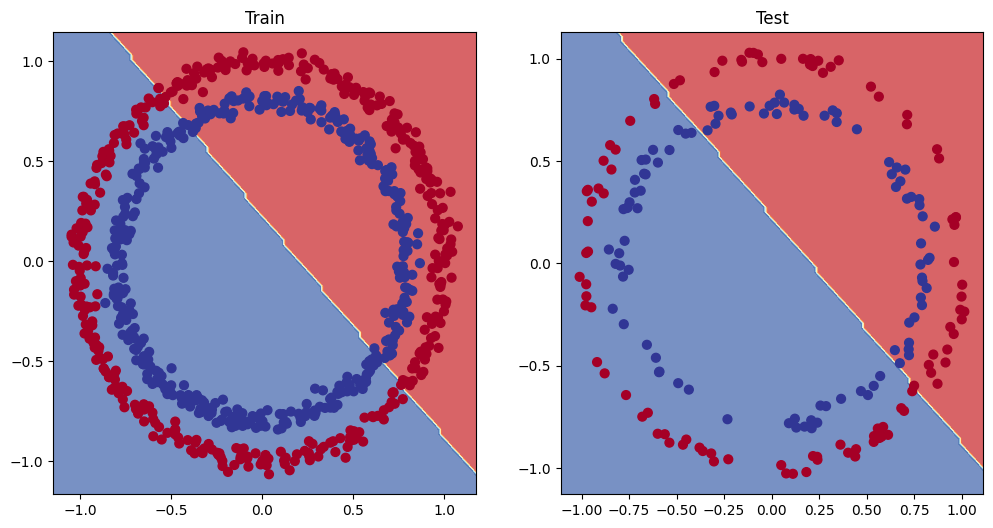

In [55]:
# Training boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

# Test boundary
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

# Our linear decision boundary obviously will not make sense in our dataset

In [56]:
# Non-linearity
import torch
from sklearn.model_selection import train_test_split

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=22)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [57]:
class CircleModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Non-linear activation function max(0, x)

  # ReLU is passed through each layer
  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model2 = CircleModel2().to(device)

In [58]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)
torch.manual_seed(22)
torch.cuda.manual_seed(22)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

In [73]:
for epoch in range(epochs):
  model2.train()
  y_logits = model2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model2.eval()
  with torch.inference_mode():
    test_logits = model2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} Loss: {loss:.4f}")

Epoch: 0 Loss: 0.0011
Epoch: 100 Loss: 0.0011
Epoch: 200 Loss: 0.0011
Epoch: 300 Loss: 0.0011
Epoch: 400 Loss: 0.0011
Epoch: 500 Loss: 0.0011
Epoch: 600 Loss: 0.0011
Epoch: 700 Loss: 0.0011
Epoch: 800 Loss: 0.0011
Epoch: 900 Loss: 0.0011


In [60]:
# Evaluate the model

model2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model2(X_test))).squeeze()

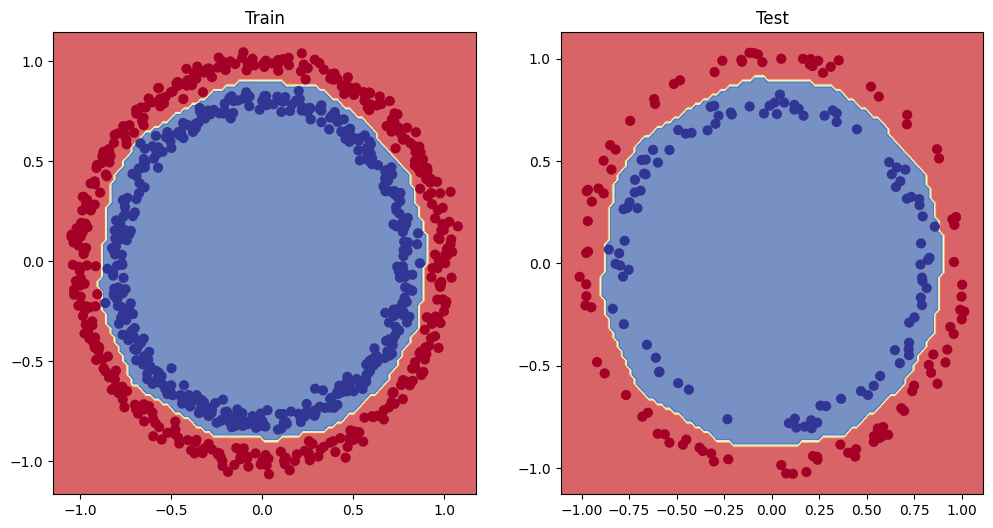

In [74]:
# Training boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)

# Test boundary
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)